# Mini version of mutrans.py model

In [1]:
import os
import logging
import math
import re
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro.distributions as dist
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyrocov import mutrans, pangolin, stats
from pyrocov.util import pretty_print

logging.basicConfig(format="%(message)s", level=logging.INFO)
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

In [2]:
def load_data_subset(*args, **kwargs):
    filename = "results/mutrans.data.single.pt"
    if os.path.exists(filename):
        dataset = torch.load(filename)
    else:
        dataset = mutrans.load_gisaid_data()
        torch.save(dataset, filename)
    dataset = mutrans.subset_gisaid_data(dataset, *args, **kwargs)
    dataset.update(mutrans.load_jhu_data(dataset))
    return dataset

queries = ["England", "USA / California", "Brazil", "India"]
dataset = load_data_subset(
    queries,
    max_strains=100,
)
locals().update(dataset)

values, indices = weekly_strains.sum([0,-1]).sort(0, descending=True)
location_id_inv = list(location_id)
for v, i in zip(values.tolist(), indices.tolist()):
    print("{: >7d} {}".format(int(v), location_id_inv[i]))
print()
for k, v in sorted(dataset.items()):
    if isinstance(v, torch.Tensor):
        print(f"{k} \t{type(v).__name__} of shape {tuple(v.shape)}")
    else:
        print(f"{k} \t{type(v).__name__} of size {len(v)}")

Selected 52/977 places, 100/1291 strains, 341/2765 mutations, 448656/1927785 samples
Loaded 511 x 3618 daily case data, totaling 210129872.0
Joining GISAID and JHU region codes
Matching 52 GISAID regions to 3618 JHU fuzzy regions


 350070 Europe / United Kingdom / England
  53729 North America / USA / California
   7875 South America / Brazil / Sao Paulo
   6809 North America / USA / Indiana
   4462 Asia / India / Maharashtra
   3065 Asia / India / Delhi
   2521 Asia / India / Telangana
   2477 South America / Brazil / Rio de Janeiro
   1841 Asia / India / West Bengal
   1727 Asia / India / Gujarat
   1142 Asia / India / Andhra Pradesh
   1012 Asia / India / Karnataka
    939 South America / Brazil / Rio Grande do Sul
    871 Asia / India / Punjab
    817 South America / Brazil / Goias
    722 Asia / India / Tamil Nadu
    633 Asia / India / Odisha
    509 Asia / India / Chhattisgarh
    487 Asia / India / Jammu and Kashmir
    425 South America / Brazil / Amazonas
    410 Asia / India / Madhya Pradesh
    409 Asia / India / Uttarakhand
    372 Asia / India / Rajasthan
    367 South America / Brazil / São Paulo
    365 South America / Brazil / Bahia
    333 Asia / India / Jharkhand
    326 Asia / India / Haryana

In [3]:
%%time
fit = mutrans.fit_svi(
    dataset,
    model_type="reparam-biased",
    cond_data={},
    guide_type="custom",
    forecast_steps=6,
    learning_rate=0.02,
    learning_rate_decay=1,
    num_steps=2001,
    clip_norm=10.0,
    rank=10,
    log_every=100,
    seed=20210319,
)
mutrans.log_stats(dataset, fit)

Fitting custom guide via SVI
init stddev = 2.55
Model has 10845 latent variables of shapes:
 coef_scale ()
 coef_decentered (341,)
 rate_scale ()
 init_loc_scale ()
 init_scale ()
 init_loc_decentered (100,)
 rate_decentered (52, 100)
 init_decentered (52, 100)
Guide has 30951 parameters of shapes:
 local_time (52, 100)
 coef_centered (341,)
 init_loc_centered (100,)
 rate_centered (100,)
 init_centered (100,)
 Guide.0.loc (342,)
 Guide.0.scale (342,)
 Guide.0.cov_factor (342, 10)
 Guide.1.locs.rate_scale ()
 Guide.1.scales.rate_scale ()
 Guide.1.locs.init_loc_scale ()
 Guide.1.scales.init_loc_scale ()
 Guide.1.locs.init_scale ()
 Guide.1.scales.init_scale ()
 Guide.1.locs.init_loc_decentered (100,)
 Guide.1.scales.init_loc_decentered (100,)
 Guide.1.locs.rate_decentered (52, 100)
 Guide.1.scales.rate_decentered (52, 100)
 Guide.1.locs.init_decentered (52, 100)
 Guide.1.scales.init_decentered (52, 100)
step    0 L=92.5625 CS=1.02 RS=0.0098 ILS=1.02 IS=1.02
step  100 L=15.009 CS=3.18 RS

CPU times: user 40.5 s, sys: 6.61 s, total: 47.1 s
Wall time: 29.7 s


{'loss': 47151.673828125,
 '|μ|/σ median': 4.158430099487305,
 '|μ|/σ max': 158.48834228515625,
 'ΔlogR(S:D614G) mean': 0.04797760769724846,
 'ΔlogR(S:D614G) std': 0.00030272011645138264,
 'ΔlogR(S:N501Y) mean': 0.010118591599166393,
 'ΔlogR(S:N501Y) std': 0.0003417752159293741,
 'ΔlogR(S:E484K) mean': -0.004993719514459372,
 'ΔlogR(S:E484K) std': 0.0013153309701010585,
 'ΔlogR(S:L452R) mean': 0.022333946079015732,
 'ΔlogR(S:L452R) std': 0.0007745507755316794,
 'R(B.1.1.7)/R(A)': 1.2365715503692627,
 'R(B.1.617.2)/R(A)': 1.8732554912567139,
 'MAE': 0.012281724251806736,
 'RMSE': 0.0569559670984745,
 'England MAE': 0.004802289418876171,
 'England RMSE': 0.029419010505080223,
 'England B.1.1.7 MAE': 0.009282471612095833,
 'England B.1.1.7 RMSE': 0.015354798175394535}

England matched 1 regions
USA / California matched 1 regions
Brazil matched 22 regions
India matched 28 regions


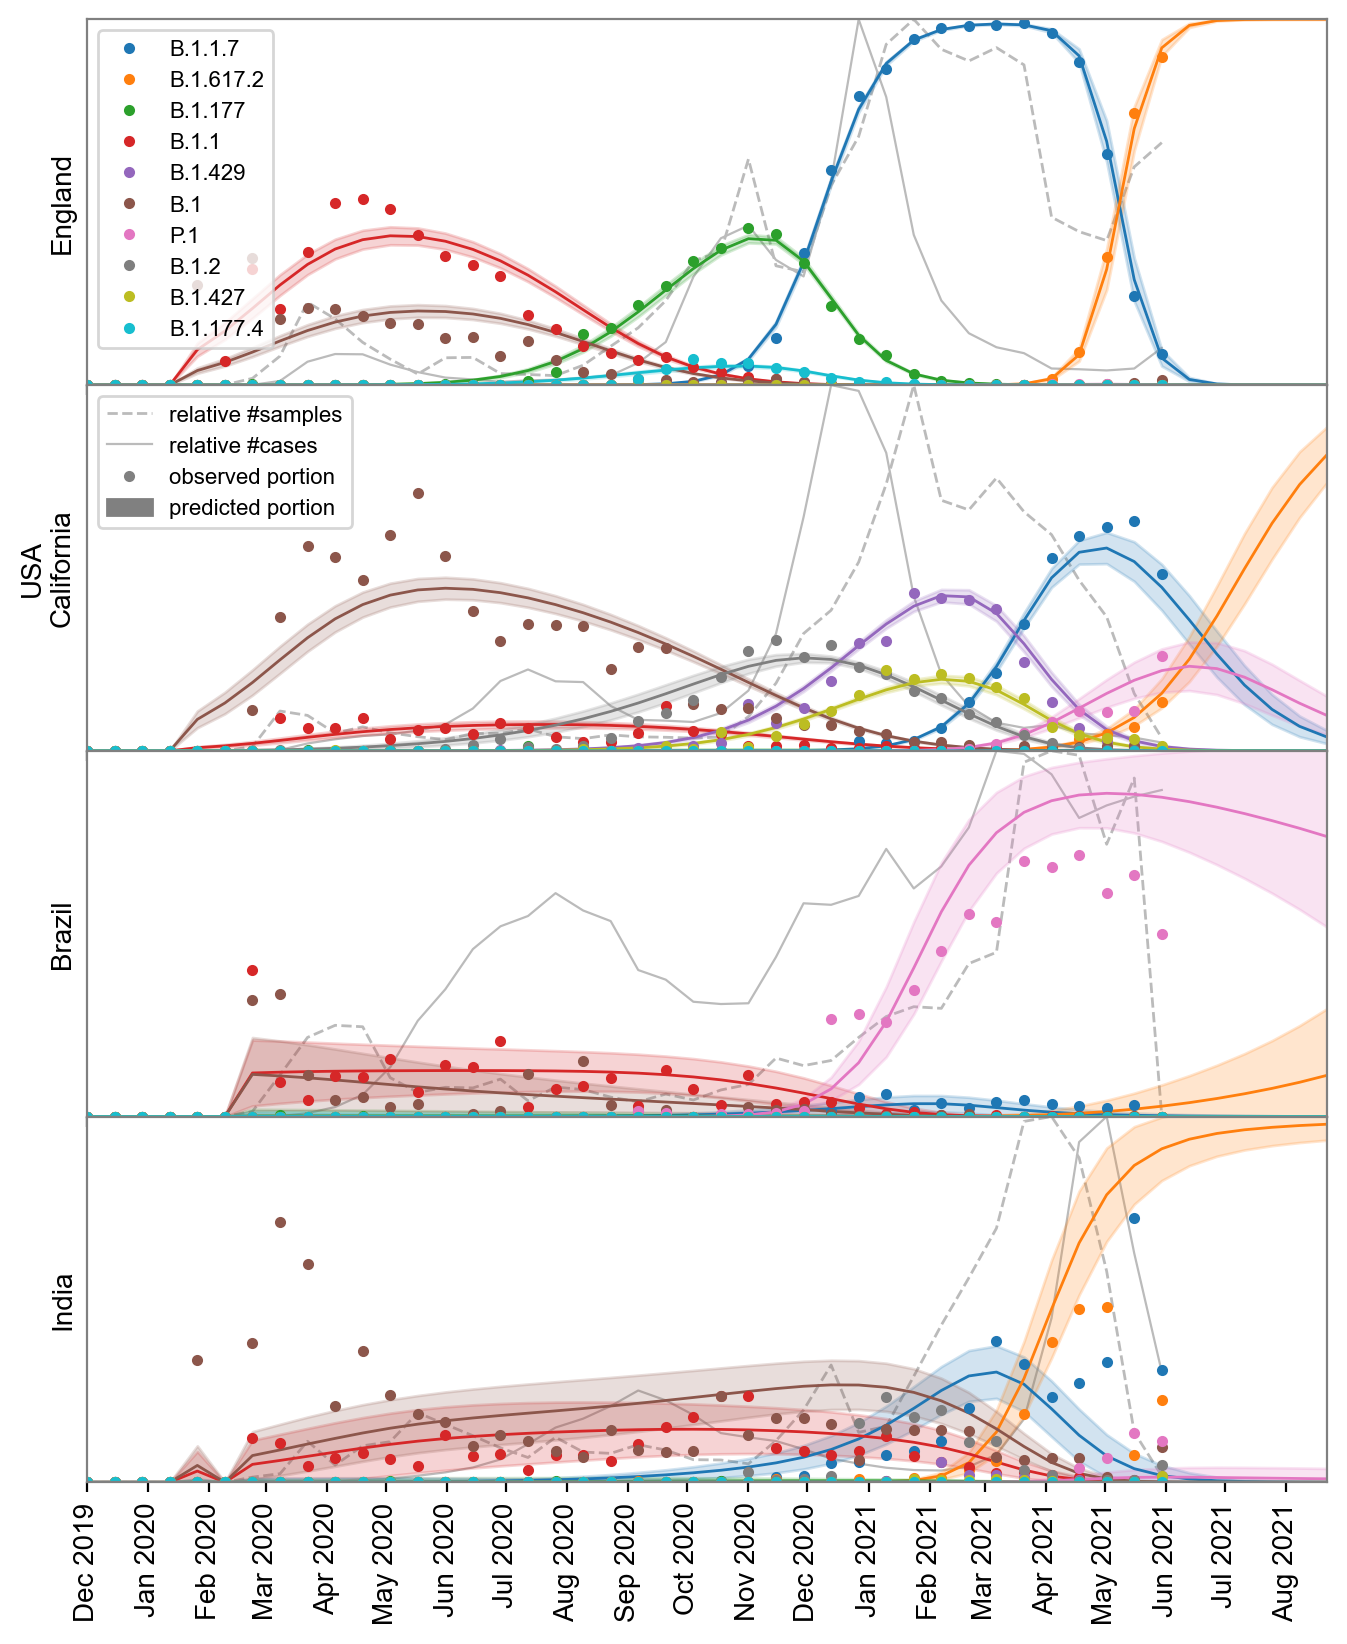

In [4]:
def plusminus(mean, std):
    p95 = 1.96 * std
    return torch.stack([mean - p95, mean, mean + p95])

def plot_forecast(fit, queries=None, num_strains=10):
    if queries is None:
        queries = list(location_id)
    elif isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1.5 + 2 * len(queries)), sharex=True)
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    dates = matplotlib.dates.date2num(mutrans.date_range(len(fit["mean"]["probs"])))
    forecast_steps = len(fit["mean"]["probs"]) - len(weekly_cases)
    assert forecast_steps >= 0
    probs = plusminus(fit["mean"]["probs"], fit["std"]["probs"])  # [3, T, P, S]
    padding = 1 + weekly_cases[-1:].expand(forecast_steps, -1)
    weekly_cases_ = torch.cat([weekly_cases, padding], 0)
    predicted = probs * weekly_cases_[..., None]
    ids = torch.tensor([i for name, i in location_id.items()
                        if any(q in name for q in queries)])
    strain_ids = weekly_strains[:, ids].sum([0, 1]).sort(-1, descending=True).indices
    strain_ids = strain_ids[:num_strains]
    colors = [f"C{i}" for i in range(10)] + ["black"] * 90
    assert len(colors) >= num_strains
    light = "#bbbbbb"
    for row, (query, ax) in enumerate(zip(queries, axes)):
        ids = torch.tensor([i for name, i in location_id.items() if query in name])
        print(f"{query} matched {len(ids)} regions")
        counts = weekly_cases[:, ids].sum(1)
        counts /= counts.max()
        ax.plot(dates[:len(counts)], counts, "k-", color=light, lw=0.8, zorder=-20)
        counts = weekly_strains[:, ids].sum([1, 2])
        counts /= counts.max()
        ax.plot(dates[:len(counts)], counts, "k--", color=light, lw=1, zorder=-20)
        pred = predicted.index_select(-2, ids).sum(-2)
        pred /= pred[1].sum(-1, True).clamp_(min=1e-8)
        obs = weekly_strains[:, ids].sum(1)
        obs /= obs.sum(-1, True).clamp_(min=1e-9)
        for s, color in zip(strain_ids, colors):
            lb, mean, ub = pred[..., s]
            ax.fill_between(dates, lb, ub, color=color, alpha=0.2, zorder=-10)
            ax.plot(dates, mean, color=color, lw=1, zorder=-9)
            strain = lineage_id_inv[s]
            ax.plot(dates[:len(obs)], obs[:, s], color=color, lw=0, marker='o', markersize=3,
                    label=strain if row == 0 else None)
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(query.replace(" / ", "\n"))
        ax.set_xlim(dates.min(), dates.max())
        if row == 0:
            ax.legend(loc="upper left", fontsize=8)
        elif row == 1:
            ax.plot([], "k--", color=light, lw=1, label="relative #samples")
            ax.plot([], "k-", color=light, lw=0.8, label="relative #cases")
            ax.plot([], lw=0, marker='o', markersize=3, color='gray',
                    label="observed portion")
            ax.fill_between([], [], [], color='gray', label="predicted portion")
            ax.legend(loc="upper left", fontsize=8)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0)
plot_forecast(fit, queries)

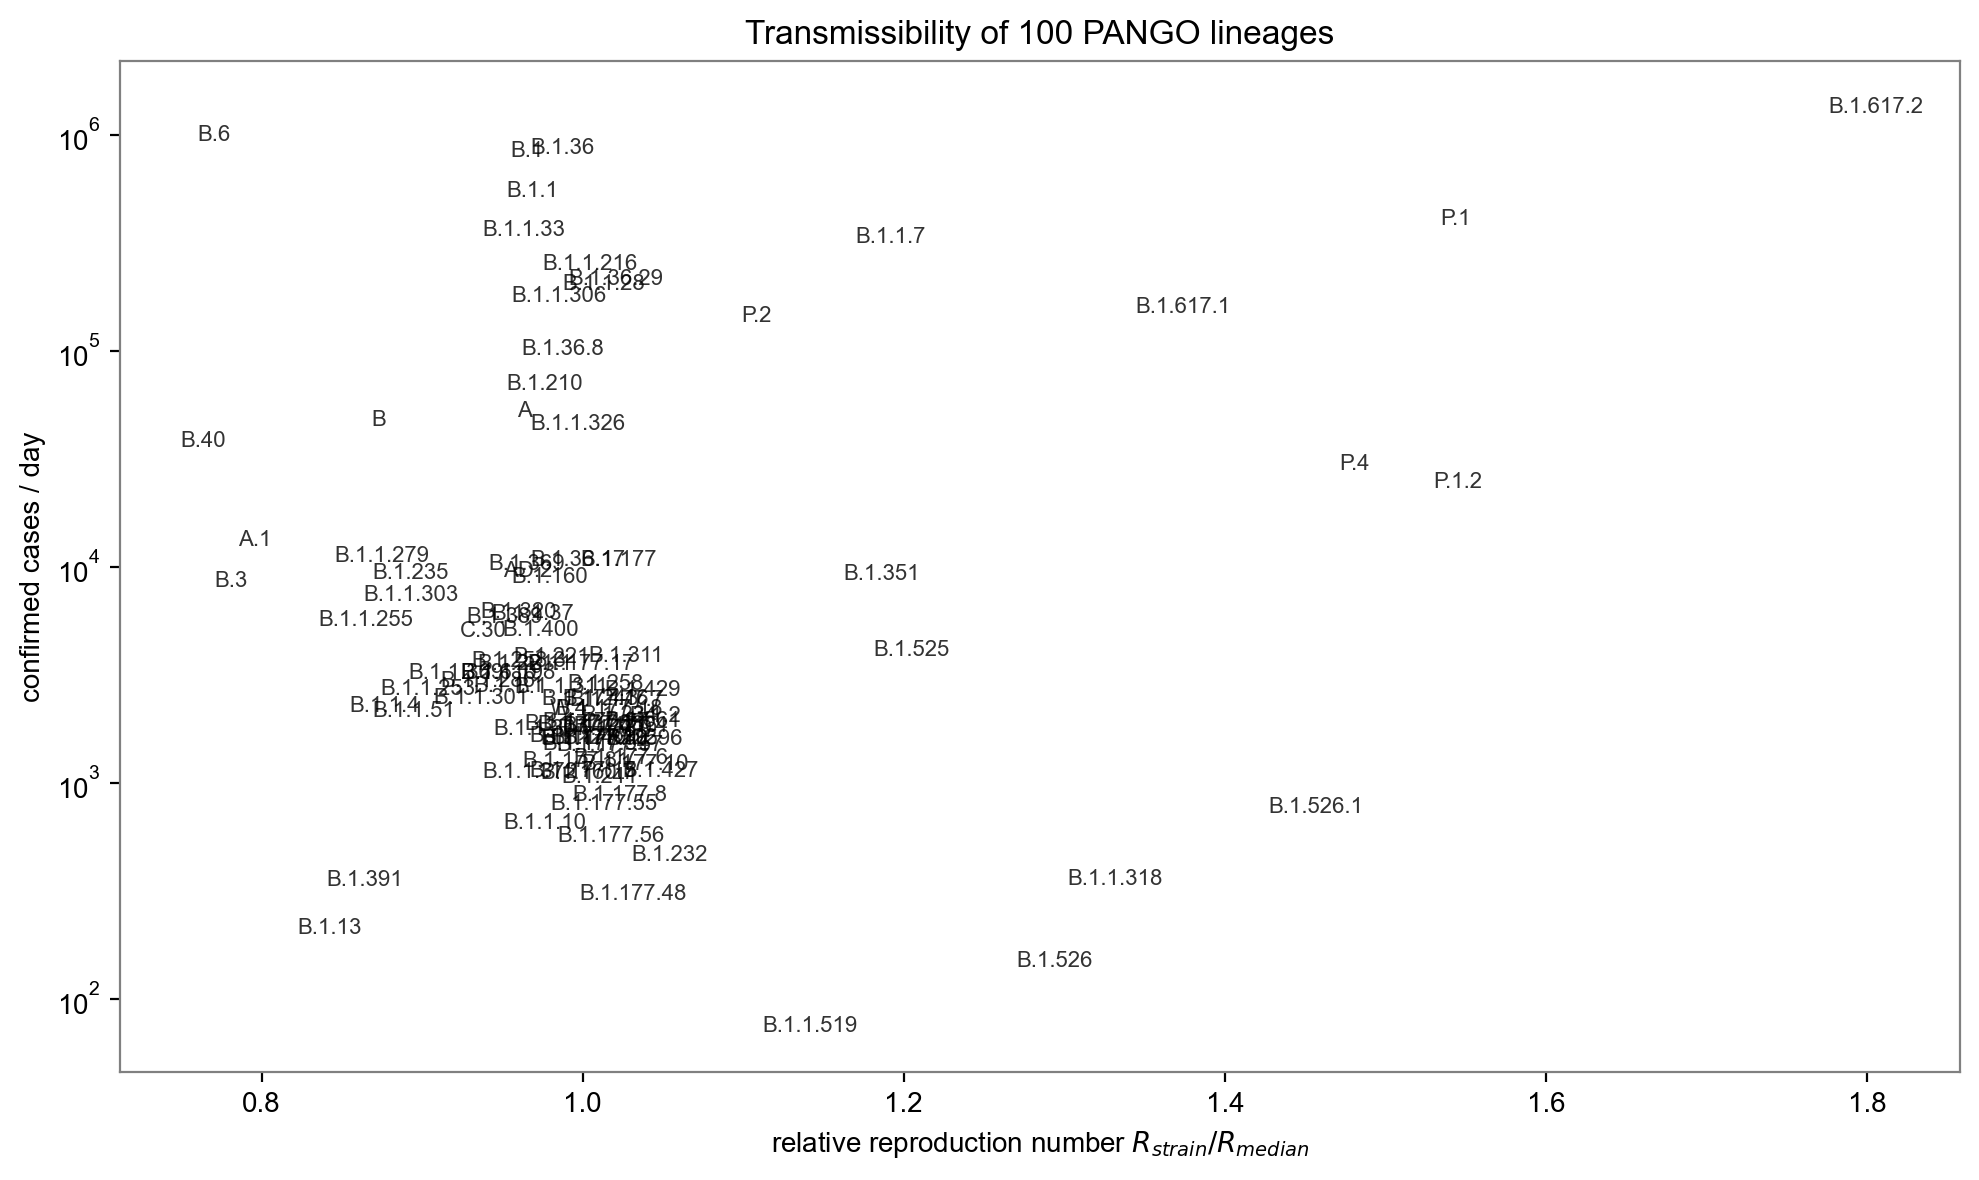

In [5]:
def plot_prevalence(fit):
    rate = fit["median"]["rate"]
    if rate.dim() == 2:
        rate = rate.mean(0)
    rate = rate - rate.median()
    R = rate.exp()
    probs = fit["mean"]["probs"].mean(0)
    cases = torch.einsum("ps,p->s", probs, weekly_cases[-2])
    cases = cases / mutrans.TIMESTEP
    plt.figure(figsize=(10, 6))
    plt.scatter(R, cases, lw=0, alpha=0)
    for name, i in lineage_id.items():
        plt.text(R[i], cases[i], name, fontsize=8, alpha=0.8,
                 horizontalalignment="center", verticalalignment="center",)
    plt.ylabel("confirmed cases / day")
    plt.yscale("symlog")
    lb10 = math.floor(10 * R.min().item())
    ub10 = math.ceil(10 * R.max().item())
    plt.xlabel("relative reproduction number $R_{strain} / R_{median}$")
    plt.title(f"Transmissibility of {len(lineage_id)} PANGO lineages")
    plt.tight_layout()

plot_prevalence(fit)

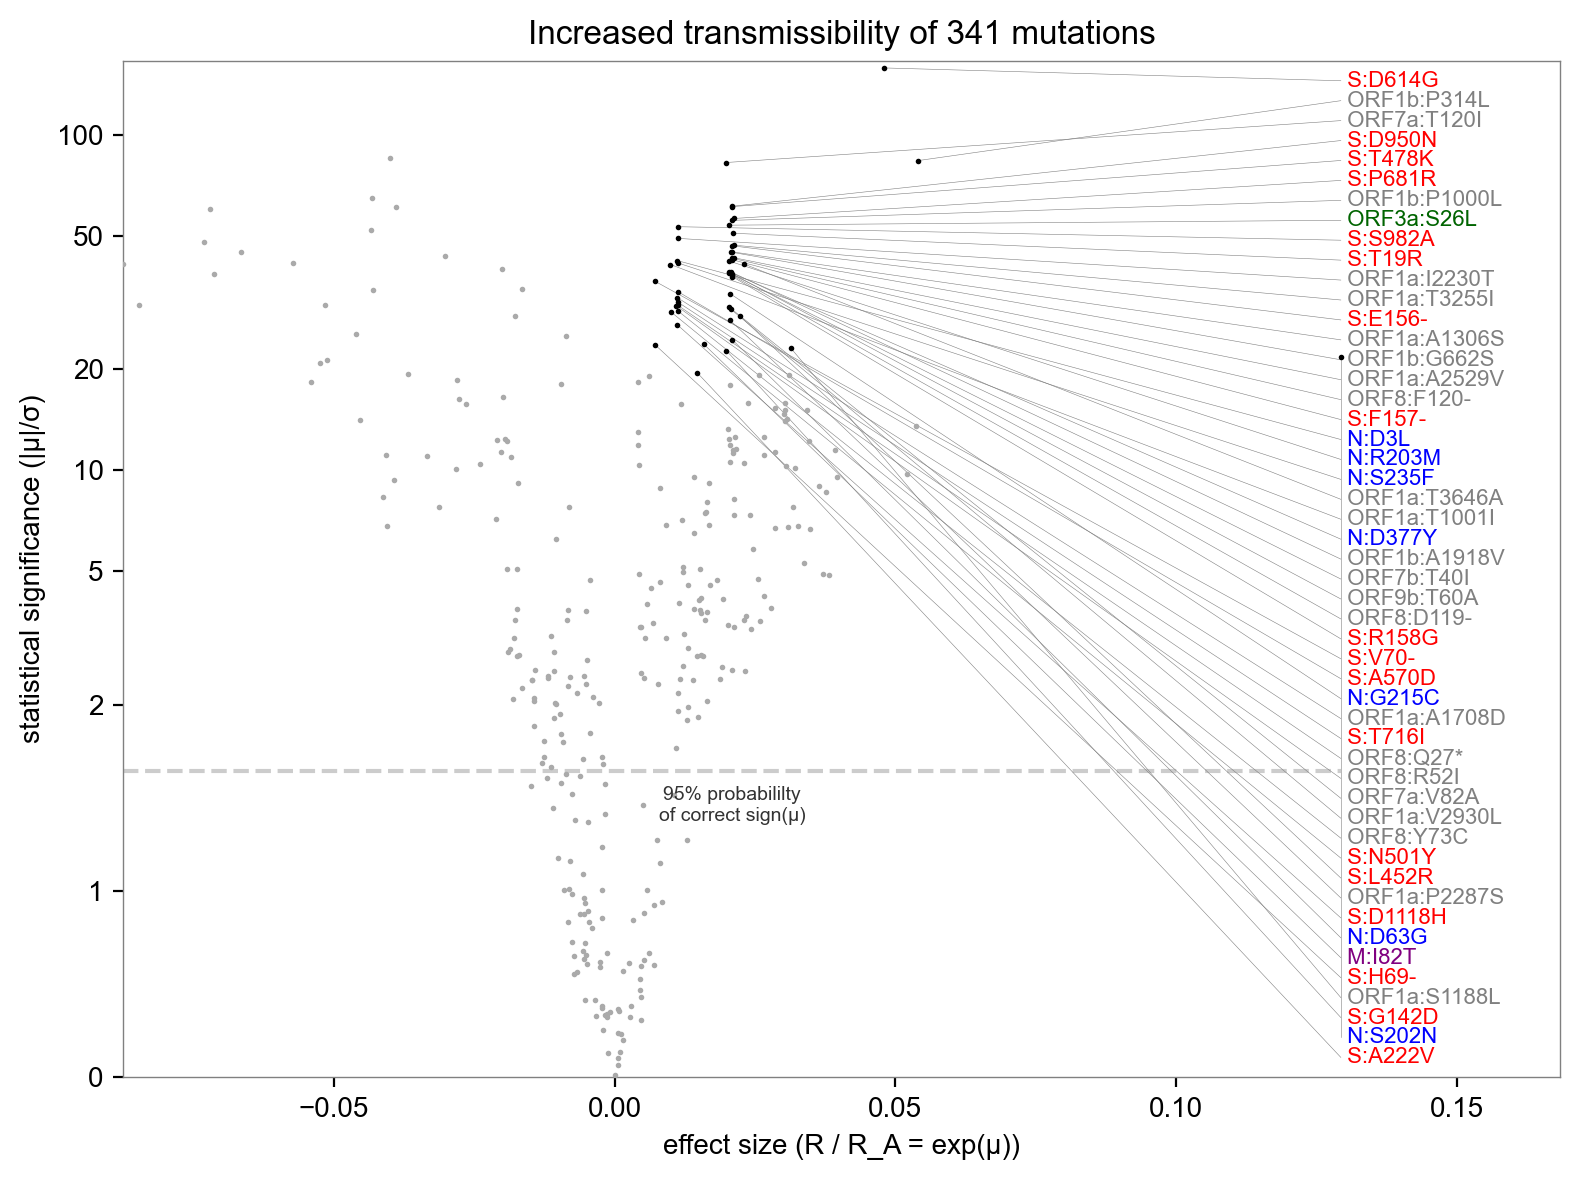

In [6]:
def plot_volcano(mean, std, linthresh=2, top_k=50):
    xs = mean * 0.01
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = top_k

    plt.figure(figsize=(8, 6))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    plt.plot(xs[pos][:N], ys[pos][:N], 'k.', lw=0, markersize=2, zorder=10)
    plt.plot(xs[pos][N:], ys[pos][N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.plot(xs[neg], ys[neg], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("effect size (R / R_A = exp(μ))")
    plt.ylabel("statistical significance (|μ|/σ)")
    lpad = 0
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.18
    plt.xlim(x0 - (x1 - x0) * lpad, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    plt.plot([x0, x1], [p95, p95], 'k--', alpha=0.2)
    comment_pos = 0.5
    plt.text((1 - comment_pos) * x0 + comment_pos * x1, p95 * 0.95,
             "95% probabililty\nof correct sign(μ)",
             fontsize=7, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF3a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()

plot_volcano(fit["mean"]["coef"], fit["std"]["coef"], linthresh=2)

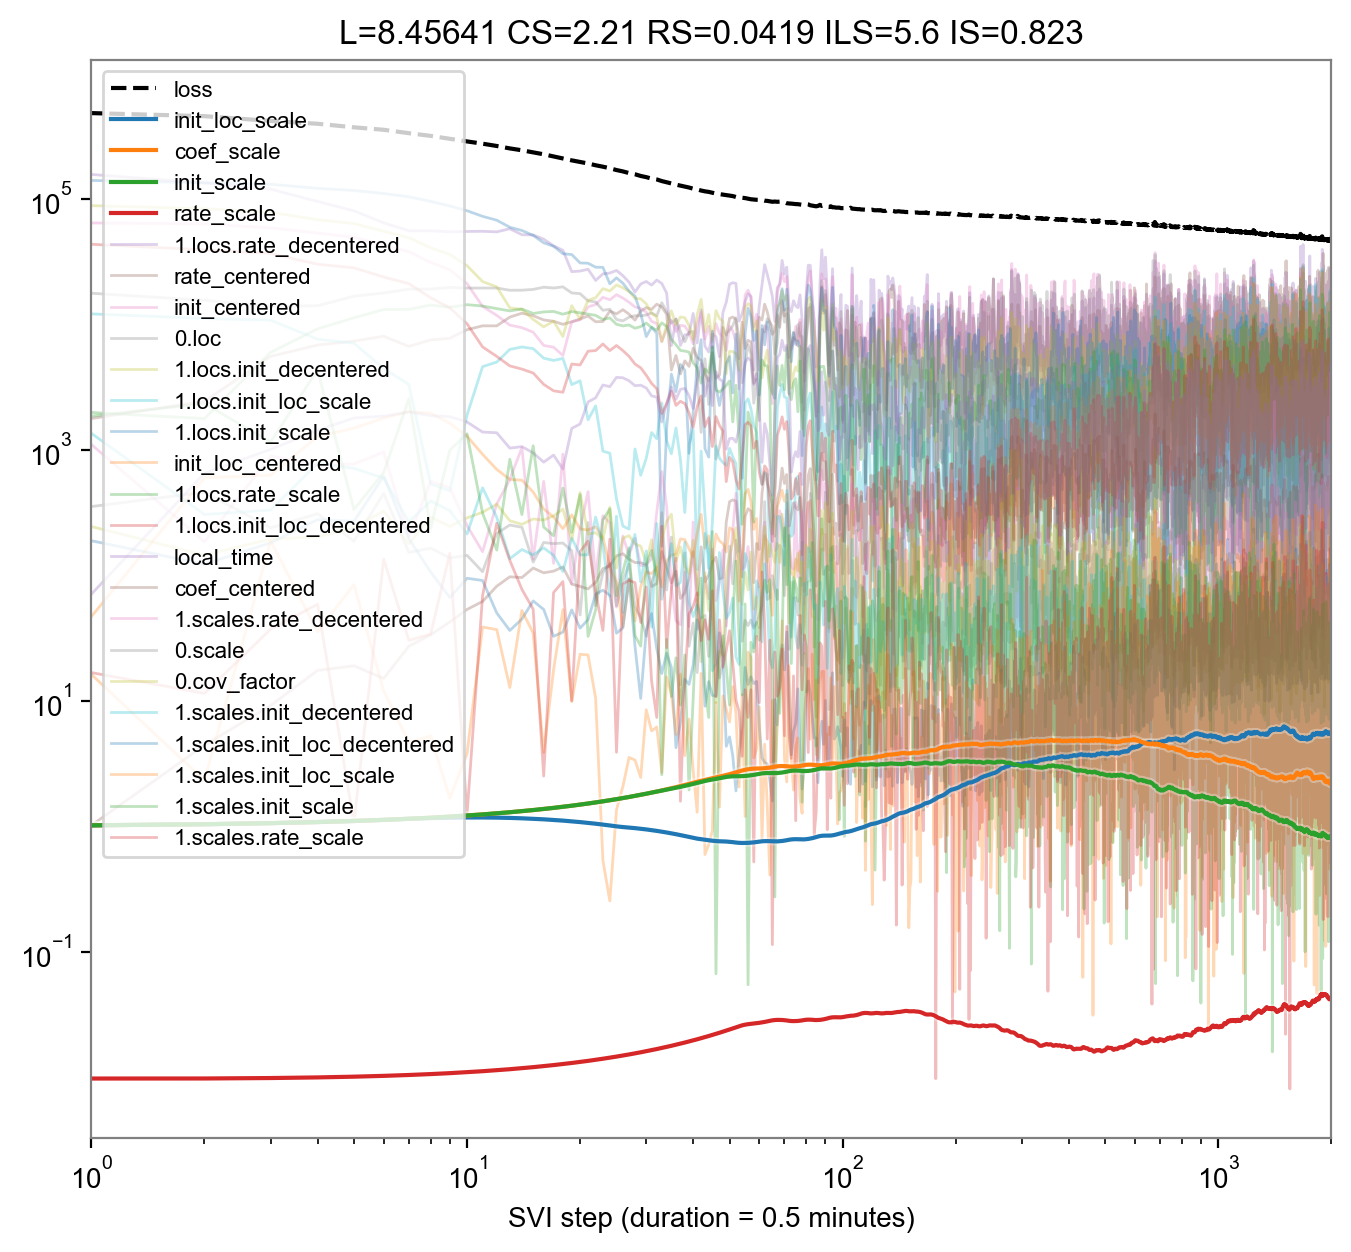

In [7]:
def plot_fit(fit):
    num_nonzero = int(torch.count_nonzero(weekly_strains))
    median = fit.get("median", fit.get("mean", {}))
    plt.figure(figsize=(8, 7))
    time = np.arange(1, 1 + len(fit["losses"]))
    plt.plot(fit["losses"], "k--", label="loss")
    locs = []
    grads = []
    for name, series in fit["series"].items():
        rankby = -torch.tensor(series).log1p().mean().item()
        if "Guide." in name:
            name = name.split("Guide.")[-1].replace("$$$", ".")
            grads.append((name, series, rankby))
        elif "_centered" in name or name == "local_time":
            grads.append((name, series, rankby))
        elif name != "loss":
            locs.append((name, series, rankby))
    locs.sort(key=lambda x: x[-1])
    grads.sort(key=lambda x: x[-1])
    for name, series, _ in locs:
        plt.plot(time, series, label=name)
    for name, series, _ in locs:
        plt.plot(time, series, color="white", lw=3, alpha=0.3, zorder=-1)
    for name, series, _ in grads:
        plt.plot(time, series, lw=1, alpha=0.3, label=name, zorder=-2)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(1, len(fit["losses"]))
    plt.legend(loc="upper left", fontsize=8)
    plt.xlabel("SVI step (duration = {:0.1f} minutes)".format(fit["walltime"]/60))
    loss = np.median(fit["losses"][-201:]) / num_nonzero
    plt.title(" ".join([f"L={loss:0.6g}"] + [
        "{}={:0.3g}".format(
            "".join(p[0] for p in k.split("_")).upper(), v
        )
        for k, v in median.items()
        if v.numel() == 1
    ]))
plot_fit(fit)

In [8]:
centered = defaultdict(list)
for k, v in fit["params"].items():
    if "_centered" in k:
        centered[k.split("_centered")[0]].append(v)
for k, v in sorted(centered.items()):
    v = torch.distributions.transform_to(dist.constraints.unit_interval)(sum(v))
    print(f"{k}: {v.min().item():0.3g} {v.mean().item():0.3g}, {v.max().item():0.3g}")

coef: 0.562 0.616, 0.64
init: 0.541 0.591, 0.635
init_loc: 0.57 0.61, 0.635
rate: 0.625 0.67, 0.7
